In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sb

from pathlib import Path

from lola.fourier import isotropic_power_spectrum
from lola.plot import draw

os.environ["PATH"] += ":/mnt/sw/nix/store/80wb60hk9c9hbi1rzbnr6kdbbjknp4ch-texlive-20220321/bin/x86_64-linux"

outdir = Path("./figures")
outdir.mkdir(exist_ok=True)

rc = {
    "axes.axisbelow": True,
    "axes.linewidth": 1.0,
    "axes.labelsize": "x-small",
    "axes.titlesize": "x-small",
    "figure.dpi": 150,
    "figure.figsize": (3.2, 3.2),
    "font.size": 12.0,
    "legend.fontsize": "xx-small",
    "lines.linewidth": 1.0,
    "savefig.transparent": True,
    "xtick.labelsize": "xx-small",
    "xtick.major.width": 1.0,
    "ytick.labelsize": "xx-small",
    "ytick.major.width": 1.0,
    "font.family": ["serif"],
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsfonts}",
}

plt.rcParams.update(rc)

## Dataframe

In [2]:
df = pd.read_csv(
    "~/ceph/lola/results/rayleigh_benard/stats.csv",
    names=[
        "run",
        "target",
        "compression",
        "method",
        "settings",
        "guidance",
        "context",
        "overlap",
        "speed",
        "split",
        "index",
        "start",
        "seed",
        "field",
        "time",
        "auto_encoded",
        "m1",
        "m2",
        "spread",
        "rmse",
        "nrmse",
        "vrmse",
        "re_total",
        "rmse_p_low",
        "rmse_c_low",
        "rmse_p_mid",
        "rmse_c_mid",
        "rmse_p_high",
        "rmse_c_high",
        "rmse_p_sub",
        "rmse_c_sub",
        "rayleigh",
        "prandtl",
        "bc00",
        "bc01",
        "bc10",
        "bc11",
    ],
    dtype={"settings": str, "guidance": str, "compression": int},
)

df = df[~df["auto_encoded"]]
df = df[df["time"] > 0]
df = df[df["start"] == 32]
df = df.sort_values(["method", "compression"], kind="stable")
df = df.merge(
    pd.DataFrame({
        "field": [0, 1, 2, 3],
        "std_global": [0.25, 0.15, 0.20, 0.20],
    })
)


def horizon(t):
    if t < 20:
        return "1:20"
    elif t < 60:
        return "21:60"
    else:
        return "61:160"


df["horizon"] = df["time"].apply(horizon)
df["std_instant"] = np.sqrt(df["m2"] - df["m1"] ** 2)
df["spread_skill"] = (df["spread"] + 1e-3) / (df["rmse"] + 1e-3)
df.loc[df["method"] == "surrogate", "spread_skill"] = 0.0

The velocity fields initially have near-zero variance, which leads to relative metrics like the VRMSE and Power spectrum RMSE to spike close to infinity. To correct for this, we mask out the metrics of fields whose instantaneous std is less than 1% of their global std.

In [3]:
mask = df["std_instant"] / df["std_global"] > 0.01


def aggregate(x):
    m = mask[x.index]
    return np.mean(x * m) / np.mean(m)

## Plots

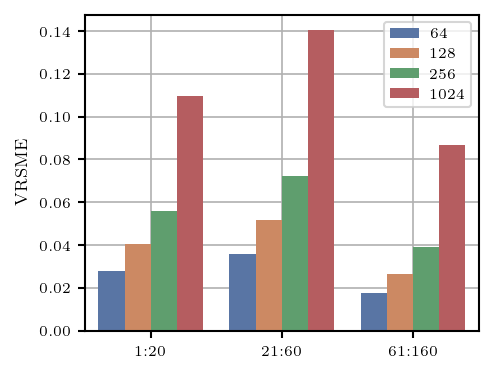

In [4]:
table = df[df["method"] == "autoencoder"]

fig = plt.figure(figsize=(3.2, 2.4))

ax = sb.barplot(
    table,
    x="horizon",
    y="vrmse",
    hue="compression",
    estimator=aggregate,
    errorbar=None,
    palette=sb.color_palette("deep", 4),
)

ax.grid()
ax.get_legend().set_title(None)

ax.set_xlabel(None)
ax.set_ylabel("VRSME")

fig.tight_layout(pad=0.33)

plt.savefig(outdir / "rb_ae.pdf", dpi=300, transparent=True)

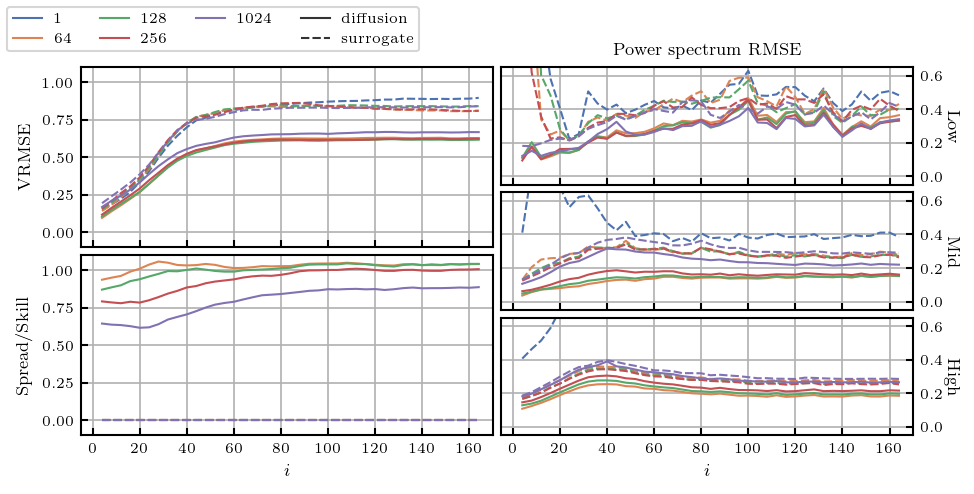

In [5]:
table = df[df["method"] != "autoencoder"]

fig, axs = plt.subplot_mosaic(
    [
        [0, 2],
        [0, 2],
        [0, 3],
        [1, 3],
        [1, 4],
        [1, 4],
    ],
    figsize=(6.4, 3.2),
    sharex=True,
    sharey=False,
)

for i, metric in enumerate(["VRMSE", "spread_skill"]):
    ax = sb.lineplot(
        table,
        x="time",
        y=metric.lower(),
        hue="compression",
        style="method",
        estimator=aggregate,
        errorbar=None,
        palette=sb.color_palette("deep", 5),
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("$i$")
    ax.set_xlim(-5, 170)
    ax.set_ylim(-0.1, 1.1)

    if metric == "spread_skill":
        ax.set_ylabel("Spread/Skill")
    else:
        ax.set_ylabel(metric)

    ax.tick_params(direction="in")

    handles, labels = ax.get_legend_handles_labels()

for i, band in enumerate(["Low", "Mid", "High"], start=2):
    ax = sb.lineplot(
        table,
        x="time",
        y=f"rmse_p_{band.lower()}",
        hue="compression",
        style="method",
        estimator=aggregate,
        errorbar=None,
        palette=sb.color_palette("deep", 5),
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("$i$")
    ax.set_xlim(-5, 170)

    ax.set_ylabel(band)
    ax.set_ylim(-0.05, 0.65)

    ax.tick_params(direction="in")

    ax.yaxis.set_label_position("right")
    ax.yaxis.label.set(rotation=-90, va="center")
    ax.yaxis.tick_right()

    if i == 2:
        ax.set_title("Power spectrum RMSE")

for i, label in reversed(list(enumerate(labels))):
    if label in ("compression", "method"):
        blank = handles.pop(i)
        labels.pop(i)

handles.insert(-2, blank)
labels.insert(-2, None)

fig.align_labels()
fig.tight_layout(pad=0.33)
fig.subplots_adjust(top=0.875)
fig.legend(handles, labels, loc="upper left", ncol=4)

plt.savefig(outdir / "rb_mosaic.pdf", dpi=300, transparent=True)

## Tables

In [6]:
table = df[["method", "compression", "horizon", "vrmse"]]

table = table.groupby(["method", "compression", "horizon"]).agg(aggregate).round(3).reset_index()
table = table.pivot(index=["method", "compression"], columns="horizon", values=["vrmse"])
# print(table.to_latex(float_format="%.3f"))
table

vrmse              
horizon                   1:20  21:60 61:160
method      compression                     
autoencoder 64           0.028  0.036  0.018
            128          0.040  0.052  0.027
            256          0.056  0.073  0.039
            1024         0.110  0.141  0.087
diffusion   64           0.162  0.469  0.625
            128          0.171  0.463  0.613
            256          0.186  0.477  0.618
            1024         0.229  0.512  0.660
surrogate   1            0.210  0.628  0.870
            64           0.214  0.646  0.826
            128          0.226  0.649  0.840
            256          0.237  0.650  0.831
            1024         0.265  0.645  0.829

In [7]:
table = df[(df["method"] != "autoencoder") & (df["compression"] > 1)]
table = table[["method", "context", "horizon", "vrmse"]]

table = table.groupby(["method", "context", "horizon"]).agg(aggregate).round(3).reset_index()
table = table.pivot(index=["method", "context"], columns="horizon", values=["vrmse"])
# print(table.to_latex(float_format="%.3f"))
table

vrmse              
horizon             1:20  21:60 61:160
method    context                     
diffusion 1        0.189  0.484  0.630
          2        0.187  0.478  0.631
          3        0.185  0.479  0.626
surrogate 1        0.229  0.625  0.822
          2        0.234  0.640  0.825
          3        0.243  0.678  0.848

In [8]:
table = df[["method", "compression", "horizon", "rmse_p_low", "rmse_p_mid", "rmse_p_high"]]

table = table.groupby(["method", "compression", "horizon"]).agg(aggregate).round(3).reset_index()
table = table.pivot(
    index=["method", "compression"],
    columns="horizon",
    values=["rmse_p_low", "rmse_p_mid", "rmse_p_high"],
)
# print(table.to_latex(float_format="%.3f"))
table

rmse_p_low               rmse_p_mid                \
horizon                       1:20  21:60 61:160       1:20  21:60 61:160   
method      compression                                                     
autoencoder 64               0.006  0.002  0.001      0.010  0.015  0.010   
            128              0.015  0.003  0.002      0.025  0.052  0.030   
            256              0.025  0.006  0.004      0.049  0.111  0.069   
            1024             0.067  0.026  0.018      0.121  0.255  0.196   
diffusion   64               0.126  0.217  0.342      0.061  0.112  0.144   
            128              0.139  0.211  0.327      0.066  0.127  0.148   
            256              0.126  0.215  0.323      0.080  0.163  0.164   
            1024             0.134  0.231  0.312      0.139  0.277  0.237   
surrogate   1                1.125  0.385  0.476      0.749  0.521  0.388   
            64               0.600  0.321  0.447      0.214  0.312  0.287   
            128              1.072  0.323  0.425      0.182  0.301  0.282   
            256              0.606  0.311  0.426      0.166  0.296  0.281   
            1024             0.194  0.304  0.396      0.176  0.336  0.310   

                        rmse_p_high                
horizon                        1:20  21:60 61:160  
method      compression                            
autoencoder 64                0.107  0.195  0.139  
            128               0.136  0.234  0.173  
            256               0.162  0.269  0.207  
            1024              0.212  0.341  0.275  
diffusion   64                0.136  0.235  0.191  
            128               0.152  0.255  0.204  
            256               0.171  0.280  0.224  
            1024              0.214  0.342  0.278  
surrogate   1                 0.497  1.031  0.832  
            64                0.213  0.335  0.282  
            128               0.199  0.322  0.269  
            256               0.198  0.317  0.265  
            1024              0.225  0.361  0.299

## Images

In [9]:
path = Path("/mnt/ceph/users/frozet/lola/videos/rayleigh_benard")

runs = df[["run", "method", "compression"]]
runs = runs.drop_duplicates()

field = 0
frames = np.array([0, 2, 4, 8, 16, 32])

for run, method, compression in runs.values:
    files = (path / run).glob("*032*.npz")
    files = sorted(files)

    for i, file in enumerate(files):
        x, x_hat = np.load(file).values()

        x = x[field, frames, ::2, :]
        x_hat = x_hat[:, field, frames, ::2, :]

        vmin = np.nanquantile(x, 0.01, keepdims=True) - 1e-2
        vmax = np.nanquantile(x, 0.99, keepdims=True) + 1e-2

        draw(x, vmin=vmin, vmax=vmax, pad=8).save(outdir / f"rb_{i}_gt.png")

        for j in range(len(x_hat)):
            draw(x_hat[j], vmin=vmin, vmax=vmax, pad=8).save(outdir / f"rb_{i}_{method}_{compression:04d}_{j}.png")

In [10]:
path = Path("/mnt/ceph/users/frozet/lola/videos/rayleigh_benard")

runs = df[["run", "method", "compression"]]
runs = runs.drop_duplicates()

field = 0
frames = np.array([2, 8, 32])

for i in range(7):
    for compression in runs["compression"].unique():
        fig, axs = plt.subplots(1, len(frames), figsize=(3 * 1.2, 1.6), sharex=True, sharey=True)

        for j, (run, _, _) in enumerate(runs[runs["compression"] == compression].values):
            files = (path / run).glob("*032*.npz")
            files = sorted(files)
            file = files[i]

            x, y = np.load(file).values()

            x = x[field, frames]
            y = y[:, field, frames]

            p_x, k = isotropic_power_spectrum(x, spatial=2)
            p_y, _ = isotropic_power_spectrum(y, spatial=2)
            p_y = p_y.mean(dim=0)

            for ii, frame in enumerate(frames):
                if j == 0:
                    axs[ii].axvline(2, color="red", linestyle="dashed")
                    axs[ii].loglog(1 / k, p_x[ii], base=2, color="black")
                axs[ii].loglog(1 / k, p_y[ii], base=2, color=f"C{j}")

                axs[ii].grid()
                axs[ii].invert_xaxis()
                axs[ii].set_xlabel("Wavelength")
                axs[ii].set_title(f"$i = {4 * frame}$")
                axs[ii].tick_params(direction="in")

            axs[0].set_ylabel("Power spectrum")

        fig.align_labels()
        fig.tight_layout(pad=0.33)

        plt.savefig(outdir / f"rb_psd_{i}_{compression:04d}.pdf", dpi=300, transparent=True)
        plt.close()